\\begin{align}
\underline{Option~Pricing~using~CRR~Models}
\end{align}


In [ ]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit


plt.rcParams['figure.figsize'] = (15, 10)










\begin{align}
\underline{Classe~Arbre~Binomiale}
\end{align}

In [ ]:


class CRROption:
    def __init__(self, S0,r,sigma,T,framework="CRR"):
        self.S0 = S0
        self.T = T
        self.r=r
        self.dt = T/N
        self.sigma = sigma
        self.u =np.exp(self.sigma*np.sqrt(self.dt))
        self.d = 1.0/(self.u)
        self.p = (np.exp(self.r * self.dt) - self.d)/(self.u - self.d)
        if framework=="RB":
          self.p = 0.5
          self.u = np.exp(self.r-0.5*(pow(self.sigma,2))*self.dt+self.sigma*np.sqrt(self.dt))
          self.u = np.exp(self.r-0.5*(pow(self.sigma,2))*self.dt-self.sigma*np.sqrt(self.dt))


    def build_tree(self):
        tree = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1):
                tree[j, i] = self.S0 * (self.d**j) * (self.u**(i-j))
        return tree

    def vanilla_option(self,K,payoff,T,method="european"):
      #return price of a path independant option using backward methodology in a CRR tree
      #parameters :
      #:payoff : a function to define outside the class taking the strike as parameters expected to return terminal Payoff
      #:framework : Optional ,  Using CRR recommendation  RB model , both fits first two moment of Black_scholes model when Grid is sufficiently small
      #:K strike of the Option
      self.dt=T/N
      tree = self.build_tree()
      Prices = payoff(tree[:,-1],K)

      for i in range(N-1, 0,-1):
          Prices=((1-self.p)*Prices[1:] + (self.p)*Prices[:-1])*np.exp(-self.r*self.dt)
          if method=="american":
            Prices = np.maximum(Prices,payoff(tree[:i,i-1],K))  #Snell envelope at every step

      return Prices[0]

    def plot_tree(self):
        tree = self.build_tree()
        fig, ax = plt.subplots()
        for i in range(N):
            for j in range(i+1):
                ax.plot([i, i+1], [-j, -(j+1)], 'b')
                ax.plot([i, i+1], [-j, -j], 'b')
                ax.plot(i, -j, 'ro')
                ax.text(i, -j-0.3, str(round(tree[j,i], 2)), ha='center', va='center')

        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Values')
        ax.set_title('CRR Binomial Tree')
        plt.axis('off')
        plt.show()





\\begin{align}
\underline{Example~of~use}
\end{align}

European/American PUT price  : 10.717530958143543 and 11.921391030128683
European/American Call price  : 5.820378913554834 and 5.820378913554834


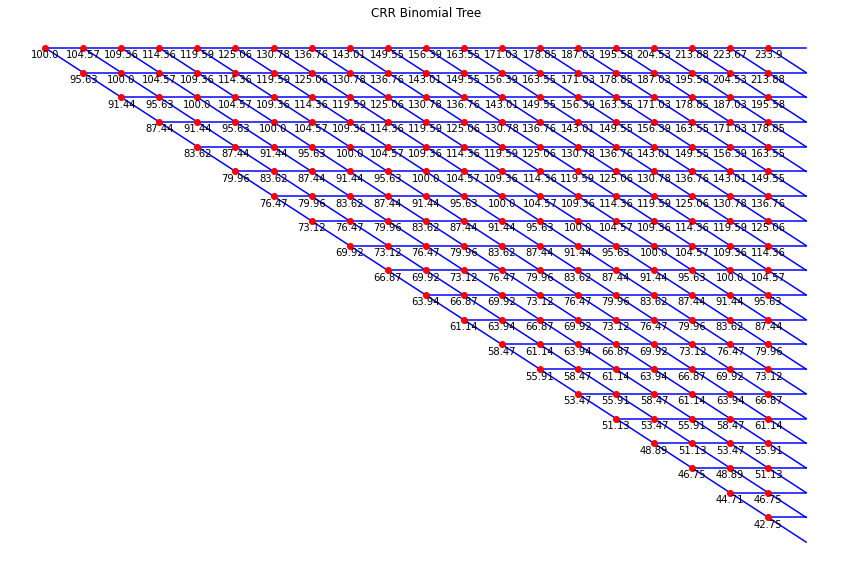

In [ ]:

#Generate your model , add the framework you want to

N = 20 #Grid precision
model = CRROption(100,0.05,0.2,1,framework="CRR")

#Define any payoff you need to with Single asset. (Pricing with correlated assets might come in future using)

def call(SO,K):
  return np.maximum(SO-K,0)
def put(SO,K):
  return np.maximum(K-SO,0)

#Plot and price Option using followings methods

print(f"European/American PUT price  : {model.vanilla_option(110,put,1)} and {model.vanilla_option(110,put,1, method='american')}")
print(f"European/American Call price  : {model.vanilla_option(110,call,1)} and {model.vanilla_option(110,call,1, method='american')}")


#Check if the CRR calibrated model fits to black scholes vanilas prices



model.plot_tree()



\begin{align}
\underline{Black~schole~framework}
\end{align}



$\boxed{\frac{dSt}{St}=rdt+\sigma dWt} $




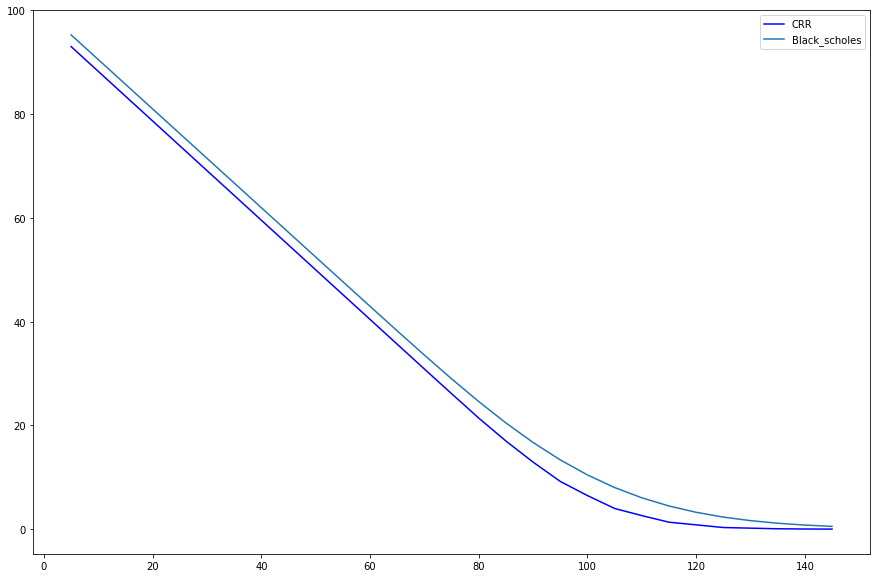

In [ ]:
#check results : Benchmark is Black_scholes prices


N = 10

def black_scholes_call(S, K, T, r, sigma):
    """
    Calcule le prix d'un call sous Black-Scholes.

    Arguments :
    S -- le prix actuel de l'actif sous-jacent
    K -- le prix d'exercice du call
    T -- la maturité du call (en années)
    r -- le taux d'intérêt sans risque (continu)
    sigma -- la volatilité du prix de l'actif sous-jacent (annuelle)

    Returns :
    Le prix du call sous Black-Scholes.
    """
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return price



strikes = np.arange(5,150,5)
L_CRR=[]
L_BS=[]

for strike in strikes:
  L_CRR.append(model.vanilla_option(strike,call,1))
  L_BS.append(black_scholes_call(100,strike,1,0.05,0.2))



plt.plot(strikes,L_CRR,color="blue",label="CRR")
plt.plot(strikes,L_BS,label="Black_scholes")
plt.legend()
plt.show()